In [1]:
#!pip install -q "transformers>=4.41" timm tqdm matplotlib
import torch
import math, torch, timm, gc
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import Dinov2Model, AutoImageProcessor
import seaborn as sns

In [2]:
import numpy as np

In [3]:
torch.random.manual_seed(1)
np.random.seed(1)

In [4]:
from torchvision.datasets.utils import download_and_extract_archive
# ================================================================
# 1.  Grab Imagenette-160 (≈16 k images, 10 ImageNet classes)
# ================================================================
# Fast-ai host provides a simple .tgz we can auto-download.
root = "imagenette2"
url  = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
if not (datasets.utils.os.path.exists(root)):
    download_and_extract_archive(url, root)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)


# ---------- 1.  Imagenette-160 (already extracted earlier) --------------
assert datasets.utils.os.path.exists(root), "Imagenette folder not found."

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
tfs = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean,
                         std =processor.image_std),
])

#ds     = datasets.ImageFolder(f"{root}/imagenette2-160/train", transform=tfs)
ds     = datasets.ImageFolder(f"{root}/imagenette2-160/val", transform=tfs)
#loader = DataLoader(ds, batch_size=32, shuffle=True,
#                    num_workers=2, pin_memory=True)
loader = DataLoader(ds, batch_size=128, shuffle=True,
                    num_workers=2, pin_memory=True)

print(f"Imagenette batches: {len(loader)}")


# ---------- 2.  DINOv2-base with attentions -----------------------------
model = Dinov2Model.from_pretrained(
            "facebook/dinov2-base",
            output_attentions=True).to(device).eval()

n_layers = model.config.num_hidden_layers   # 12
n_heads  = model.config.num_attention_heads # 12
print(f"DINOv2-B/14  • layers={n_layers}  heads={n_heads}")

Imagenette batches: 31
DINOv2-B/14  • layers=12  heads=12


In [6]:
def orc_curvature_discrete(attn: torch.Tensor,
                           alpha: float = 0.5,
                           eps: float = 1e-12) -> torch.Tensor:
    """
    Ollivier–Ricci curvature under the 0/1 discrete metric **without**
    explicitly allocating the distance matrix.

    Parameters
    ----------
    attn  : (B, N, N)   soft-maxed attention (rows sum to 1)
    alpha : float       idleness parameter (default 0.5)
    eps   : float       numerical guard (unused here but kept for symmetry)

    Returns
    -------
    kappa : (B, N, N)   curvature matrix
    """
    B, N, _ = attn.shape

    # 1.  μ_v  ←  α·attn + (1-α)·δ_v     (idleness mix)
    eye = torch.eye(N, device=attn.device, dtype=attn.dtype)
    mu  = alpha * attn + (1 - alpha) * eye                  # (B,N,N)

    # 2.  W₁(μ_v, μ_u)  = ½‖μ_v − μ_u‖₁  (closed form for discrete metric)
    w1 = 0.5 * torch.cdist(mu, mu, p=1)                     # (B,N,N)

    # also reqsonable
    #diff = mu.unsqueeze(2) - mu.unsqueeze(1)       # (B,N,N,N)
    #w1   = 0.5 * diff.abs().sum(dim=-1)

    # 3.  κ_OR = 1 − W₁ / 1   →   1 − W₁   (off-diagonal)
    kappa = 1.0 - w1                                        

    # 4.  ensure diagonal exactly 1  (since W₁(v,v) = 0)
    kappa.diagonal(dim1=1, dim2=2).fill_(1.0)

    return kappa

In [7]:
# ---------- 4.  Forward pass + curvature per layer ----------------------
#layer_sum, layer_count = torch.zeros(n_layers), 0
curvatures = []

layer_count = 0
with torch.no_grad():
    for batch in tqdm(loader, total=len(loader)):
        x = batch[0].to(device)
        batch_size = x.size(0)
        outs = model(pixel_values=x, output_attentions=True)
        attn = torch.stack(outs.attentions, dim=1)             # (B,L,H,257,257)
        #attn = attn[..., 1:, 1:].mean(2).to(device)            # (B,L,256,256)
        attn = attn[..., 1:, 1:].to(device) # (B,L,H,256,256)
        attn = attn.transpose(1, 2) # B x H x L x 256 x 256
        num_heads = attn.size(1)
        num_layers = attn.size(2)
        N = attn.size(-1)
        attn = attn.reshape(batch_size * num_heads, num_layers, N, N)

        # curvature layer-wise
        layer_curvatures = []
        for layer in range(n_layers):
            curvature = orc_curvature_discrete(attn[:, layer])
            curvature = curvature.reshape(batch_size, num_heads, N, N)
            #layer_sum[layer] += torch.mean(curvature).item() * batch_size
            layer_curvatures.append(curvature.mean((2, 3)).cpu())
        layer_curvatures = torch.stack(layer_curvatures, dim=1) # batch x layers x heads
        curvatures.append(layer_curvatures)

        layer_count += batch_size
        #del x, outs, attn; torch.cuda.empty_cache()

        #if layer_count >= 1024:
        #    break

curvatures = torch.concatenate(curvatures, dim=0)
#curvature_mean = (layer_sum / layer_count).tolist()

  0%|          | 0/31 [00:00<?, ?it/s]

# Averaged across heads

In [8]:
print(curvatures.shape) # batch x layers x heads

torch.Size([3925, 12, 12])


In [9]:
curvatures2 = curvatures.mean(2) # mean across heads
curvatures_mean, curvatures_std = curvatures2.mean(0), curvatures2.std(0)

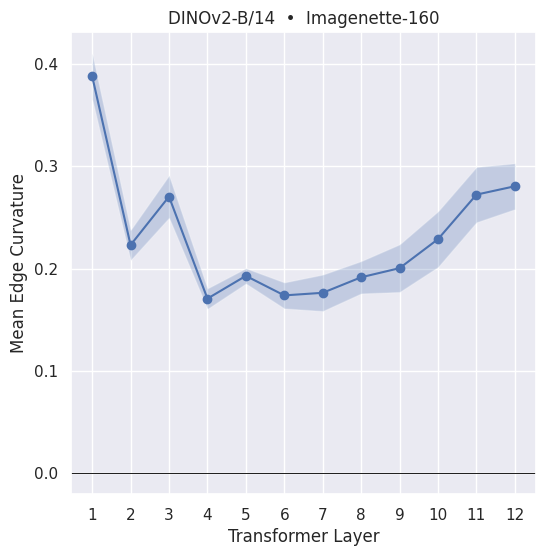

In [10]:
layers = range(1, n_layers+1)

sns.set_theme()
plt.figure(figsize=(6,6))
plt.plot(layers, curvatures_mean, marker='o')
plt.fill_between(
    layers,
    curvatures_mean - curvatures_std,
    curvatures_mean + curvatures_std,
    alpha=0.25                      # light shading
)
plt.axhline(0, color='k', lw=0.7)
plt.xticks(layers)
plt.xlabel("Transformer Layer")
plt.ylabel("Mean Edge Curvature")
plt.title("DINOv2-B/14  •  Imagenette-160")
#plt.grid()
plt.savefig("fig1.png")
plt.show()

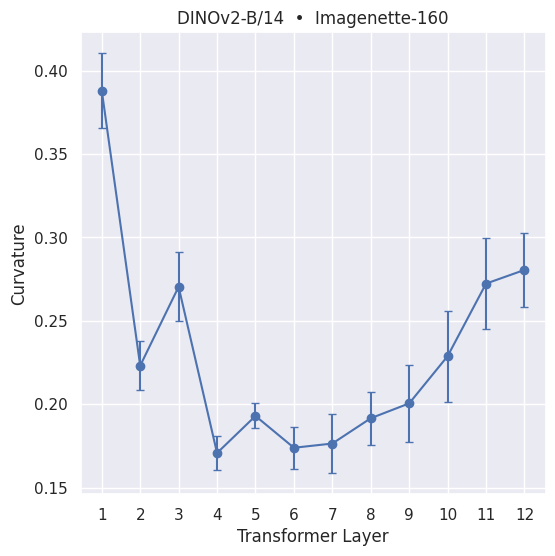

In [11]:
sns.set_theme()
plt.figure(figsize=(6,6))
plt.errorbar(
    x=range(1, n_layers+1),
    y=curvatures_mean,
    yerr=curvatures_std,           # 1-σ bars
    marker='o',
    capsize=3,                     # small vertical “caps” on each bar
)
#plt.axhline(0, color='k', lw=0.7)
plt.xticks(range(1, n_layers+1))
plt.xlabel("Transformer Layer")
plt.ylabel("Curvature")
plt.title("DINOv2-B/14  •  Imagenette-160")
plt.savefig("fig2.png")
plt.show()
#plt.grid(); plt.show()

# Each head is separate

In [12]:
B, L, H = curvatures.shape
layers  = np.arange(1, L + 1)

# 1.  aggregate over batch
curv_mean = curvatures.mean(axis=0)        # (L, H)
curv_std  = curvatures.std(axis=0)         # (L, H)

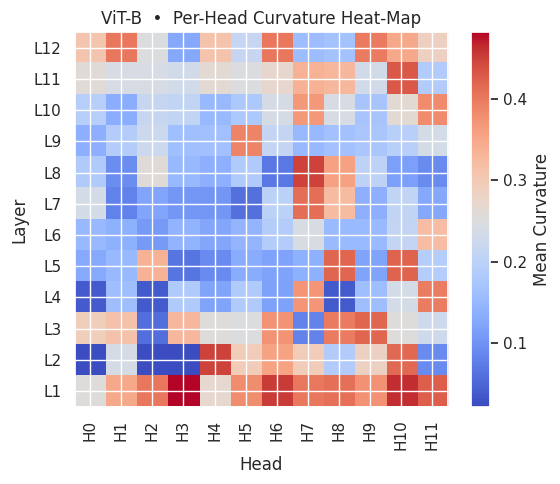

In [13]:
# curv_mean: (L, H)   already averaged over batch
plt.figure(figsize=(H * 0.4 + 1, 5))
plt.imshow(curv_mean, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Mean Curvature')
plt.xticks(np.arange(H), labels=[f'H{h}' for h in range(H)], rotation=90)
plt.yticks(np.arange(L), labels=[f'L{l+1}' for l in range(L)])
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('ViT-B  •  Per-Head Curvature Heat-Map')
plt.tight_layout()
plt.savefig("fig3.png")
plt.show()

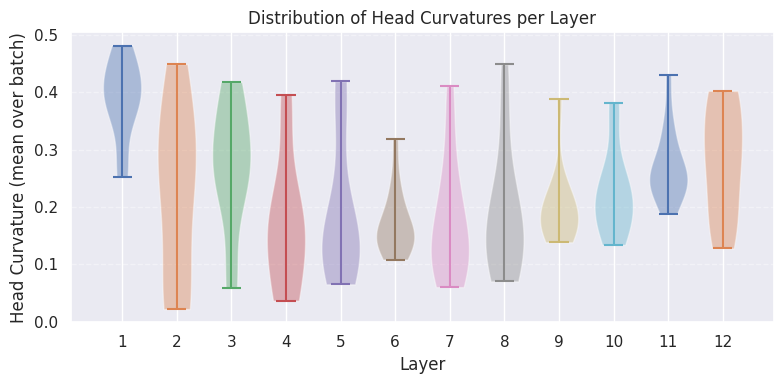

In [14]:
plt.figure(figsize=(8, 4))
for l in range(L):
    # collect all H heads' curvature means for this layer
    data = curv_mean[l]            # shape (H,)

    # violin (or switch to plt.boxplot)
    parts = plt.violinplot(
        dataset=data,
        positions=[l+1],
        showmeans=False,
        showextrema=True,
        widths=0.7
    )
    for pc in parts['bodies']:
        pc.set_alpha(0.4)

plt.axhline(0, color='k', lw=0.6)
plt.xticks(np.arange(1, L+1))
plt.xlabel('Layer')
plt.ylabel('Head Curvature (mean over batch)')
plt.title('Distribution of Head Curvatures per Layer')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("fig4.png")
plt.show()


# Per class

In [ ]:
from collections import defaultdict

n_layers = model.config.num_hidden_layers          # 12 for ViT-B

# ------------------------------------------------------------------
# 1.  Containers
# ------------------------------------------------------------------
all_curvatures   = []                              # overall (for old use-case)
class_buckets    = defaultdict(list)               # label → [T_i]

seen = 0                                           # images processed

# ------------------------------------------------------------------
# 2.  Forward loop
# ------------------------------------------------------------------
with torch.no_grad():
    for batch in tqdm(loader, total=len(loader)):
        x, y = (t.to(device) for t in batch)       # x: (B,3,H,W)   y: (B,)
        B = x.size(0)

        # 2-a  get attention  --------------------------------------
        outs  = model(pixel_values=x, output_attentions=True)
        attn  = torch.stack(outs.attentions, dim=1)        # (B,L,H,257,257)
        attn  = attn[..., 1:, 1:]                          # drop CLS → (B,L,H,256,256)
        attn  = attn.transpose(1, 2)                      # (B,H,L,256,256)
        H     = attn.size(1); L = attn.size(2); N = attn.size(-1)
        attn  = attn.reshape(B * H, L, N, N)

        # 2-b  curvature per layer  -------------------------------
        layer_curvs = []
        for ℓ in range(n_layers):
            κ = orc_curvature_discrete(attn[:, ℓ])                           # (B·H, N, N)
            κ = κ.reshape(B, H, N, N)                     # restore heads
            layer_curvs.append(κ.mean((2, 3)).cpu())      # (B, H)
        layer_curvs = torch.stack(layer_curvs, dim=1)     # (B, L, H)

        # 2-c  store                                          
        all_curvatures.append(layer_curvs)                # old global list

        for i, label in enumerate(y.cpu().tolist()):
            class_buckets[label].append(layer_curvs[i])   # per-class

        seen += B
        #if seen >= 1024:
        #    break

# ------------------------------------------------------------------
# 3.  Collate tensors
# ------------------------------------------------------------------
all_curvatures = torch.concat(all_curvatures, 0)          # (N_img, L, H)

# class_buckets[label] → stack into a single tensor per class
class_curvatures = {
    lbl: torch.stack(t_list, 0)                           # (n_lbl, L, H)
    for lbl, t_list in class_buckets.items()
}

# optional: pre-compute mean/std per class for quick plotting
#class_stats = {
#    lbl: {
#        "mean": t.mean(0),    # (L, H)
#        "std" : t.std(0)      # (L, H)
#    }
#    for lbl, t in class_curvatures.items()
#}

  0%|          | 0/31 [00:00<?, ?it/s]

In [16]:
# optional: pre-compute mean/std per class for quick plotting
class_stats = {
    lbl: {
        "mean": t.mean(2).mean(0),    # (L)
        "std" : t.mean(2).std(0)      # (L)
    }
    for lbl, t in class_curvatures.items()
}

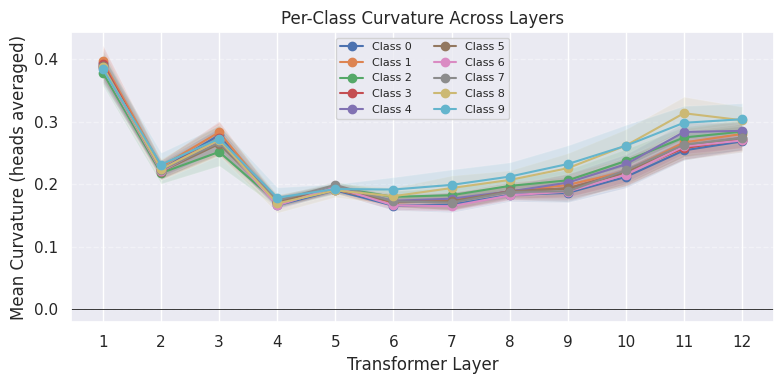

In [17]:
num_layers = next(iter(class_stats.values()))["mean"].numel()
layers     = np.arange(1, num_layers + 1)

sns.set_theme()
plt.figure(figsize=(8, 4))

for lbl in sorted(class_stats.keys()):
    μ = class_stats[lbl]["mean"].cpu().numpy()    # (L,)
    σ = class_stats[lbl]["std"].cpu().numpy()     # (L,)

    plt.plot(layers, μ, marker='o', lw=1.5, label=f"Class {lbl}")
    plt.fill_between(layers, μ - σ, μ + σ, alpha=0.15)

plt.axhline(0, color='k', lw=0.6)
plt.xticks(layers)
plt.xlabel("Transformer Layer")
plt.ylabel("Mean Curvature (heads averaged)")
plt.title("Per-Class Curvature Across Layers")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig("fig5.png")
plt.show()

# Correct vs Missclassifications

In [ ]:
from transformers import Dinov2ForImageClassification  # or AutoModelForImageClassification

model = Dinov2ForImageClassification.from_pretrained(
    "facebook/dinov2-base-imagenet1k-1-layer",   # or your fine-tuned checkpoint
    output_attentions=True                       # still get per-layer attention
).to(device)

# ---------- 4.  Forward pass + curvature, split by correctness ----------
curv_correct, curv_wrong = [], []        # list[Tensor] … batch x layers x heads
n_seen = 0

with torch.no_grad():
    for batch in tqdm(loader, total=len(loader)):
        x, y = batch[0].to(device), batch[1].to(device)        # images, labels
        bs = x.size(0)

        outs   = model(pixel_values=x, output_attentions=True)
        logits = outs.logits                                    # (B, num_classes)
        pred   = logits.argmax(dim=-1)
        is_correct = pred.eq(y)                                 # (B,)

        # --------------- prepare attention --------------------
        attn = torch.stack(outs.attentions, dim=1)              # (B,L,H,257,257)
        attn = attn[..., 1:, 1:].to(device)                     # (B,L,H,256,256)
        attn = attn.transpose(1, 2)                             # (B,H,L,256,256)
        H, L, N = attn.size(1), attn.size(2), attn.size(-1)
        attn = attn.reshape(bs * H, L, N, N)                    # ((B·H),L,N,N)

        # --------------- curvature per layer ------------------
        per_layer = []
        for layer in range(L):
            curv = orc_curvature_discrete(attn[:, layer])       # ((B·H),N,N)
            curv = curv.reshape(bs, H, N, N)                    # (B,H,N,N)
            per_layer.append(curv.mean((2, 3)))           # (B,H)

        per_layer = torch.stack(per_layer, dim=1)               # (B,L,H)

        # --------------- split & store ------------------------
        curv_correct.append(per_layer[is_correct].detach().cpu())
        curv_wrong  .append(per_layer[~is_correct].detach().cpu())

        n_seen += bs
        #if n_seen >= 1024:                                      # early-stop cap
        #    break

# tensors of shape (num_correct, L, H) / (num_wrong, L, H)
curv_correct = torch.concatenate(curv_correct, dim=0)
curv_wrong   = torch.concatenate(curv_wrong,   dim=0)

  0%|          | 0/31 [00:00<?, ?it/s]

In [19]:
# Example: mean curvature over samples & heads per layer
cc = curv_correct.mean(2)
cw = curv_wrong.mean(2)

mean_curv_correct = cc.mean(0)   # (L,)
mean_curv_wrong   = cw.mean(0)  # (L,)

std_curv_correct = cc.std(0)   # (L,)
std_curv_wrong   = cw.std(0)   # (L,)

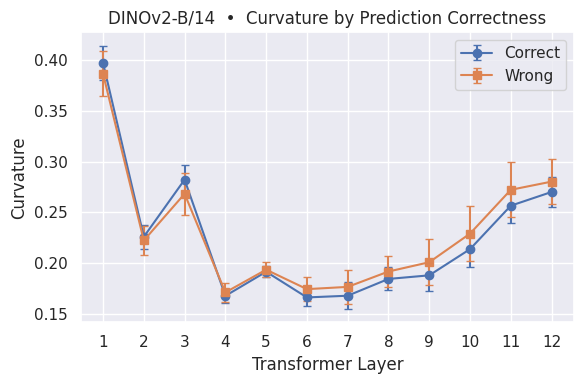

In [20]:
sns.set_theme()

n_layers = mean_curv_correct.shape[0]
layers   = range(1, n_layers + 1)

plt.figure(figsize=(6, 4))

# correct predictions
plt.errorbar(
    layers,
    mean_curv_correct,
    yerr=std_curv_correct,
    marker='o',
    capsize=3,
    label='Correct'
)

# mis-classifications
plt.errorbar(
    layers,
    mean_curv_wrong,
    yerr=std_curv_wrong,
    marker='s',          # a different marker helps readability
    capsize=3,
    label='Wrong'
)

plt.xticks(layers)
plt.xlabel("Transformer Layer")
plt.ylabel("Curvature")
plt.title("DINOv2-B/14  •  Curvature by Prediction Correctness")
plt.legend()
plt.tight_layout()
plt.savefig("fig6.png")
plt.show()

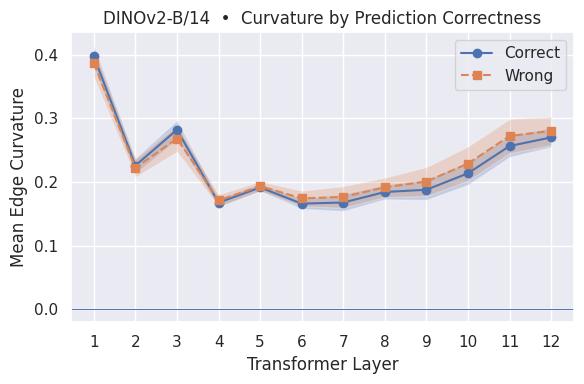

In [21]:
sns.set_theme()

n_layers = mean_curv_correct.shape[0]
layers   = range(1, n_layers + 1)

plt.figure(figsize=(6, 4))

# ── correct predictions ──────────────────────────────────────────
plt.plot(layers, mean_curv_correct, marker='o', label='Correct')
plt.fill_between(
    layers,
    mean_curv_correct - std_curv_correct,
    mean_curv_correct + std_curv_correct,
    alpha=0.25
)

# ── mis-classifications ─────────────────────────────────────────
plt.plot(layers, mean_curv_wrong, marker='s', linestyle='--', label='Wrong')
plt.fill_between(
    layers,
    mean_curv_wrong - std_curv_wrong,
    mean_curv_wrong + std_curv_wrong,
    alpha=0.25
)

plt.axhline(0, lw=0.7)
plt.xticks(layers)
plt.xlabel("Transformer Layer")
plt.ylabel("Mean Edge Curvature")
plt.title("DINOv2-B/14  •  Curvature by Prediction Correctness")
plt.legend()
plt.tight_layout()
plt.savefig("fig7.png")
plt.show()

# Train a small vision transformer

In [22]:
torch.set_grad_enabled(True)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm.auto import tqdm

# -----------------------------
# 1.  Data preparation
# -----------------------------
# assume imagenette2-160 is already downloaded/extracted under "imagenette2"
root = "imagenette2/imagenette2-160/train"
# reuse the same normalization as DINOv2
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean,
                         std =processor.image_std),
])

full_ds   = datasets.ImageFolder(root, transform=transform)
num_classes = len(full_ds.classes)

# split into train/val
train_size = int(0.9 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False,
                          num_workers=2, pin_memory=True)


class SmallViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=14,
                 in_chans=3,
                 num_classes=10,
                 embed_dim=256,
                 depth=12,
                 num_heads=8,
                 mlp_ratio=4.0,
                 dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim   = embed_dim
        self.depth       = depth
        self.num_heads   = num_heads

        # patch embedding
        self.proj = nn.Conv2d(in_chans,
                              embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

        # class token + positional embedding
        #self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=False)
        self.pos_embed = nn.Parameter(torch.zeros(1,
                                                 self.num_patches + 1,
                                                 embed_dim))
        self.pos_drop  = nn.Dropout(dropout)

        # build transformer blocks with explicit MultiheadAttention
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'attn': nn.MultiheadAttention(embed_dim,
                                              num_heads,
                                              dropout=dropout,
                                              batch_first=True),
                'norm1': nn.LayerNorm(embed_dim),
                'mlp': nn.Sequential(
                    nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
                    nn.Dropout(dropout),
                ),
                'norm2': nn.LayerNorm(embed_dim),
            })
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        #nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x, return_attn: bool = False):
        """
        x : (B, 3, H, W)
        return_attn : if True, also return a tensor of shape
                      (B, depth, num_heads, N, N)
        """
        B = x.size(0)
        # patch embed → (B, E, H/ps, W/ps) → (B, N, E)
        x = self.proj(x).flatten(2).transpose(1, 2)

        # prepend class token
        cls = torch.zeros(B, 1, self.embed_dim, device=x.device)
        #cls = self.cls_token.expand(B, -1, -1)          # (B,1,E)
        x = torch.cat((cls, x), dim=1)                  # (B, N+1, E)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        attn_maps = []  # collect if requested
        for blk in self.blocks:
            # self-attention
            if return_attn:
                attn_out, attn_w = blk['attn'](x, x, x, need_weights=True, average_attn_weights=False)
                # attn_w: (B, num_heads, N, N)
                attn_maps.append(attn_w)
            else:
                attn_out, _ = blk['attn'](x, x, x, need_weights=False)

            # first residual + norm
            x = x + attn_out
            x = blk['norm1'](x)

            # MLP block
            mlp_out = blk['mlp'](x)
            x = x + mlp_out
            x = blk['norm2'](x)

        x = self.norm(x)
        cls_final = x[:, 0]            # (B, E)
        logits    = self.head(cls_final)

        if return_attn:
            # stack → (B, depth, num_heads, N, N)
            attn_tensor = torch.stack(attn_maps, dim=1)
            return logits, attn_tensor

        return logits

In [23]:
# -----------------------------
# 3.  Training setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallViT(
    img_size=224, patch_size=14,
    in_chans=3, num_classes=num_classes,
    embed_dim=256, depth=12, num_heads=8,
    mlp_ratio=4.0, dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=3e-4,
                        weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                T_max=10)

num_epochs = 25

# -----------------------------
# 4.  Training loop
# -----------------------------
for epoch in range(1, num_epochs + 1):
    # --- train ---
    model.train()
    total_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # --- validate ---
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch:2d} — Loss: {avg_loss:.4f} — Val Acc: {val_acc:.4f}")
    scheduler.step()


Epoch 1 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  1 — Loss: 2.3006 — Val Acc: 0.1975


Epoch 2 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  2 — Loss: 2.1467 — Val Acc: 0.2080


Epoch 3 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  3 — Loss: 1.9687 — Val Acc: 0.2809


Epoch 4 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  4 — Loss: 1.8819 — Val Acc: 0.3738


Epoch 5 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14898924f880>
Traceback (most recent call last):
  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x14898924f880>
  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

 Traceback (most recent call last):
      File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14898924f880>
Traceback (most recent call last):
  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", li

Epoch  5 — Loss: 1.6929 — Val Acc: 0.4741


Epoch 6 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  6 — Loss: 1.4812 — Val Acc: 0.4572


Epoch 7 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  7 — Loss: 1.3417 — Val Acc: 0.5185


Epoch 8 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  8 — Loss: 1.2074 — Val Acc: 0.5818


Epoch 9 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch  9 — Loss: 1.0918 — Val Acc: 0.5903


Epoch 10 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 10 — Loss: 1.0204 — Val Acc: 0.6072


Epoch 11 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 11 — Loss: 0.9948 — Val Acc: 0.6072


Epoch 12 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 12 — Loss: 0.9962 — Val Acc: 0.6135


Epoch 13 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 13 — Loss: 1.0247 — Val Acc: 0.6030


Epoch 14 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 14 — Loss: 1.0674 — Val Acc: 0.5903


Epoch 15 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 15 — Loss: 1.0983 — Val Acc: 0.5966


Epoch 16 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 16 — Loss: 1.1900 — Val Acc: 0.5480


Epoch 17 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14898924f880>
Traceback (most recent call last):
  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x14898924f880>^
^Traceback (most recent call last):
^  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
^^    ^self._shutdown_workers()^
^  File "/n/ba_lab/Everyone/mjacobs/conda/envs/slot_attention6/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
^
      File "/n/ba_lab/Everyone/mjacobs/conda/en

Epoch 17 — Loss: 1.2026 — Val Acc: 0.5671


Epoch 18 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 18 — Loss: 1.2338 — Val Acc: 0.5945


Epoch 19 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 19 — Loss: 1.1950 — Val Acc: 0.5639


Epoch 20 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 20 — Loss: 1.2294 — Val Acc: 0.5512


Epoch 21 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 21 — Loss: 1.1810 — Val Acc: 0.5333


Epoch 22 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 22 — Loss: 1.1370 — Val Acc: 0.5597


Epoch 23 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 23 — Loss: 1.0298 — Val Acc: 0.5829


Epoch 24 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 24 — Loss: 0.9412 — Val Acc: 0.6283


Epoch 25 [train]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 25 — Loss: 0.8359 — Val Acc: 0.6283


In [26]:
ds     = datasets.ImageFolder(f"imagenette2/imagenette2-160/val", transform=tfs)
#loader = DataLoader(ds, batch_size=32, shuffle=True,
#                    num_workers=2, pin_memory=True)
loader = DataLoader(ds, batch_size=128, shuffle=True,
                    num_workers=2, pin_memory=True)

In [27]:
# ---------- 4.  Forward pass + curvature per layer with SmallViT ----------
curvatures = []
layer_count = 0

# we assume `loader` is your DataLoader over raw images,
# and `model` is an instance of SmallViT already on `device`

with torch.no_grad():
    for batch in tqdm(loader, total=len(loader)):
        x = batch[0].to(device)            # (B,3,224,224)
        B = x.size(0)
        
        # get logits AND attentions
        logits, attn = model(x, return_attn=True)
        # attn: (B, depth, num_heads, tokens, tokens)
        
        # drop the class‐token row & col (idx 0)
        attn = attn[..., 1:, 1:]           # (B, L, H, P, P)
        
        # reorder to match your old code: B x H x L x P x P
        #print(attn.shape)
        attn = attn.permute(0, 2, 1, 3, 4)
        _, H, L, N, _ = attn.shape
        
        # flatten batch & heads so we can loop over layers
        attn_flat = attn.reshape(B * H, L, N, N)  # (B*H, L, N, N)
        
        # compute curvature layer‐wise
        layer_curvatures = []
        for layer_idx in range(L):
            # slice out this layer's (B*H, N, N) attention
            attn_layer = attn_flat[:, layer_idx]
            
            # compute OR curvature → (B*H, N, N)
            curv = orc_curvature_discrete(attn_layer)
            
            # reshape back to (B, H, N, N) to average over tokens
            curv = curv.reshape(B, H, N, N)
            
            # mean over the N×N edges
            layer_curvatures.append(curv.mean((2, 3)).cpu())  # (B, H) → mean over heads next
            
        # stack → (B, L, H)
        layer_curvatures = torch.stack(layer_curvatures, dim=1)
        curvatures.append(layer_curvatures)  # append (B, L, H)
        
        layer_count += B

# concatenate batches → (total_images, L, H)
curvatures = torch.cat(curvatures, dim=0)

# if you want mean+std across heads (and later across images):
curvatures2      = curvatures.mean(2)      # mean over heads → (total_images, L)
curvatures_mean  = curvatures2.mean(0)     # mean over images → (L,)
curvatures_std   = curvatures2.std(0)      # std  over images → (L,)


  0%|          | 0/31 [00:00<?, ?it/s]

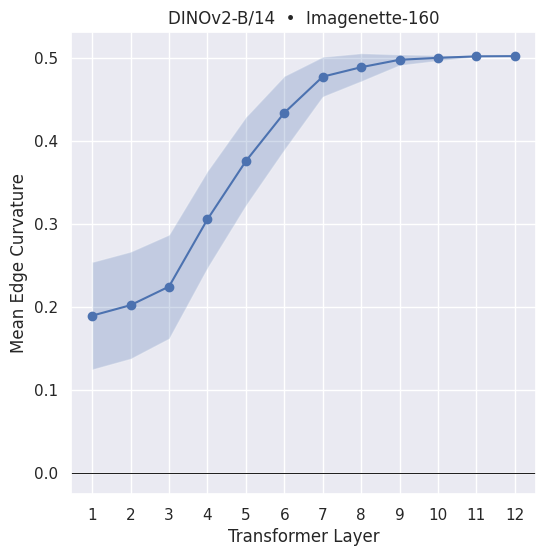

In [28]:
layers = range(1, n_layers+1)

sns.set_theme()
plt.figure(figsize=(6,6))
plt.plot(layers, curvatures_mean, marker='o')
plt.fill_between(
    layers,
    curvatures_mean - curvatures_std,
    curvatures_mean + curvatures_std,
    alpha=0.25                      # light shading
)
plt.axhline(0, color='k', lw=0.7)
plt.xticks(layers)
plt.xlabel("Transformer Layer")
plt.ylabel("Mean Edge Curvature")
plt.title("DINOv2-B/14  •  Imagenette-160")
#plt.grid()
plt.savefig("fig1_nm.png")
plt.show()

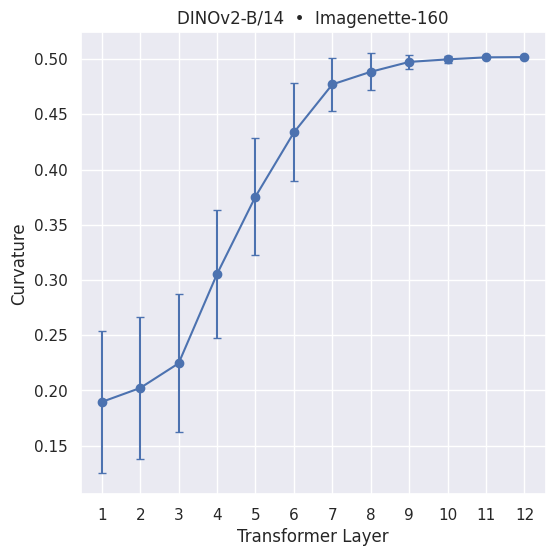

In [29]:
sns.set_theme()
plt.figure(figsize=(6,6))
plt.errorbar(
    x=range(1, n_layers+1),
    y=curvatures_mean,
    yerr=curvatures_std,           # 1-σ bars
    marker='o',
    capsize=3,                     # small vertical “caps” on each bar
)
#plt.axhline(0, color='k', lw=0.7)
plt.xticks(range(1, n_layers+1))
plt.xlabel("Transformer Layer")
plt.ylabel("Curvature")
plt.title("DINOv2-B/14  •  Imagenette-160")
plt.savefig("fig2_nm.png")
plt.show()
#plt.grid(); plt.show()